
# Прогнозирование уровня средней заработной платы в России.

Трофимович.

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

1. Визуальный анализ ряда
2. Стабилизация дисперсии (при необходимости)
3. Выбор порядка дифференцирования
4. Выбор начальных приближений для p, q, P, Qp,q,P,Q
5. Обучение и сравнение моделей-кандидатов, выбор победителя
6. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Qp,q,P,Q.
7. Прогнозирование с помощью финальной модели.

In [50]:
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from itertools import product
import warnings

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Загружаем файл.

In [4]:
salary = pd.read_csv("WAG_C_M.csv", sep = ";", index_col=['month'], parse_dates=['month'], dayfirst=True)
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


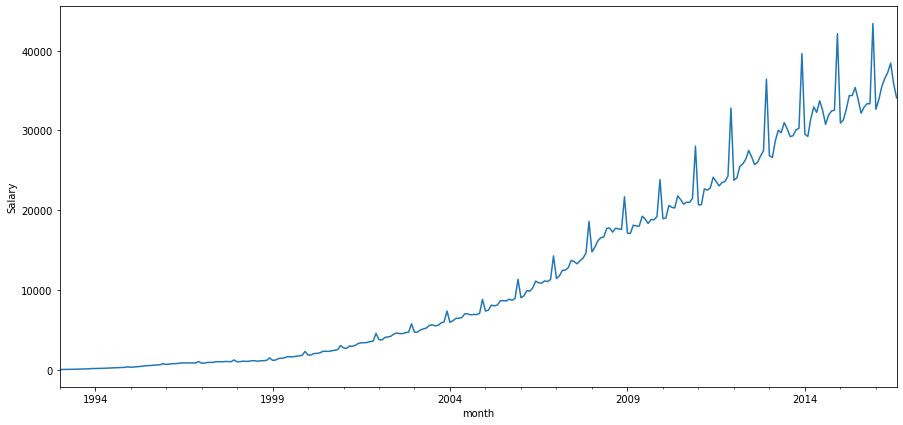

In [13]:
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()

1. Визуальный анализ:

*   наблюдается выраженная сезонность;
*   есть тренд;
*   не стационарна дисперсия;
*   судя по графику, стационарность отсутствует.



Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

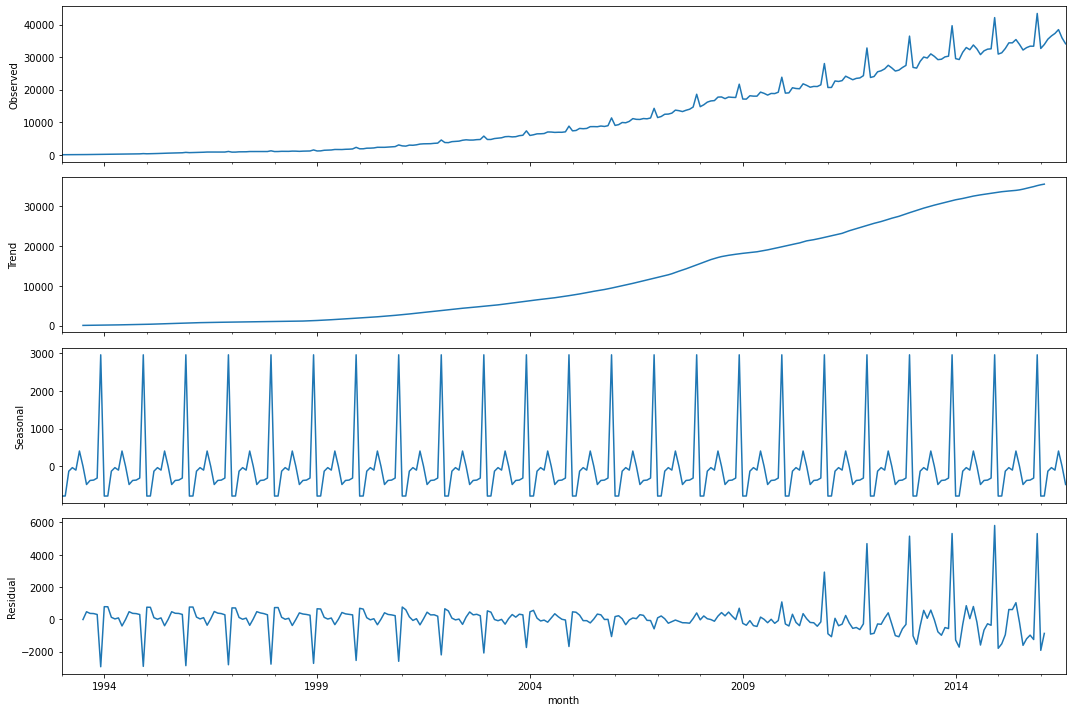

In [15]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

Гипотеза о нестационарности ряда не отвергается (достигаемый уровень значимости критерия Дики-Фуллера p=0.99 >> 0.5).

В результате декомпозиции наблюдается ярко выраженные тренд и сезонность.

Очевидно, что ряд не стационарен.

2. Стабилизация дисперсии.

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


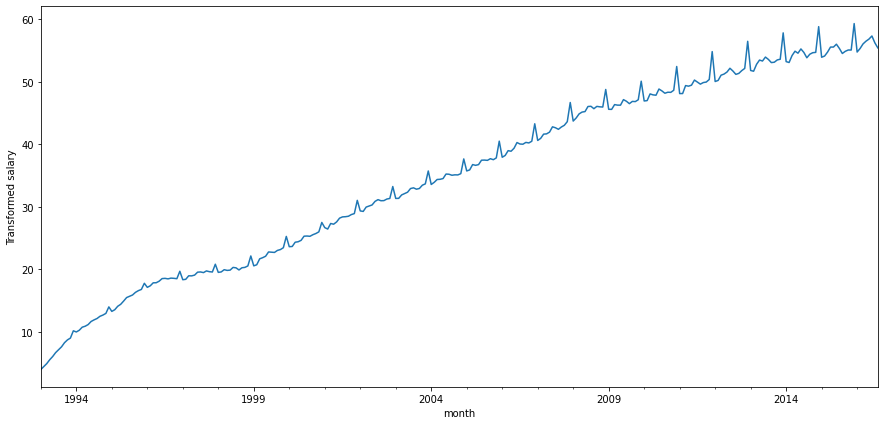

In [21]:
salary['salary_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.salary_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

Значение p-value критерия Дики-Фуллера значительно уменьшилось, но, очевидно, что ряд всё ещё не стационарен.

3. Выбор порядка дифференцирования

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

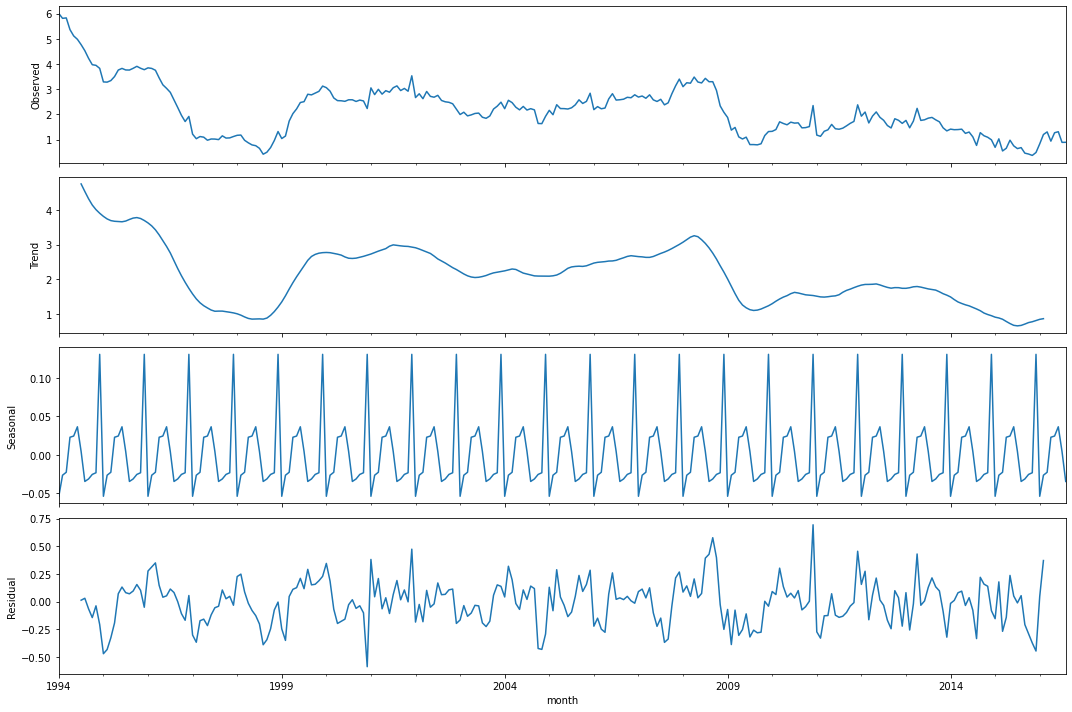

In [23]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff[12:])[1])

In [28]:
salary.salary_box_diff[:20]

month
1993-01-01         NaN
1993-02-01         NaN
1993-03-01         NaN
1993-04-01         NaN
1993-05-01         NaN
1993-06-01         NaN
1993-07-01         NaN
1993-08-01         NaN
1993-09-01         NaN
1993-10-01         NaN
1993-11-01         NaN
1993-12-01         NaN
1994-01-01    6.005802
1994-02-01    5.813697
1994-03-01    5.830905
1994-04-01    5.366650
1994-05-01    5.116965
1994-06-01    4.982199
1994-07-01    4.770434
1994-08-01    4.530375
Name: salary_box_diff, dtype: float64

P-value для критерия Дики-Фуллера: p=0.014697 < 0.05. Гипотеза о нестационарности отвергается.

Однако, ряд всё ещё не похож на стационарный. Характер тренда изменился, но всё ещё далёк от постоянного.


Добавим обысное дифференцирование.

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

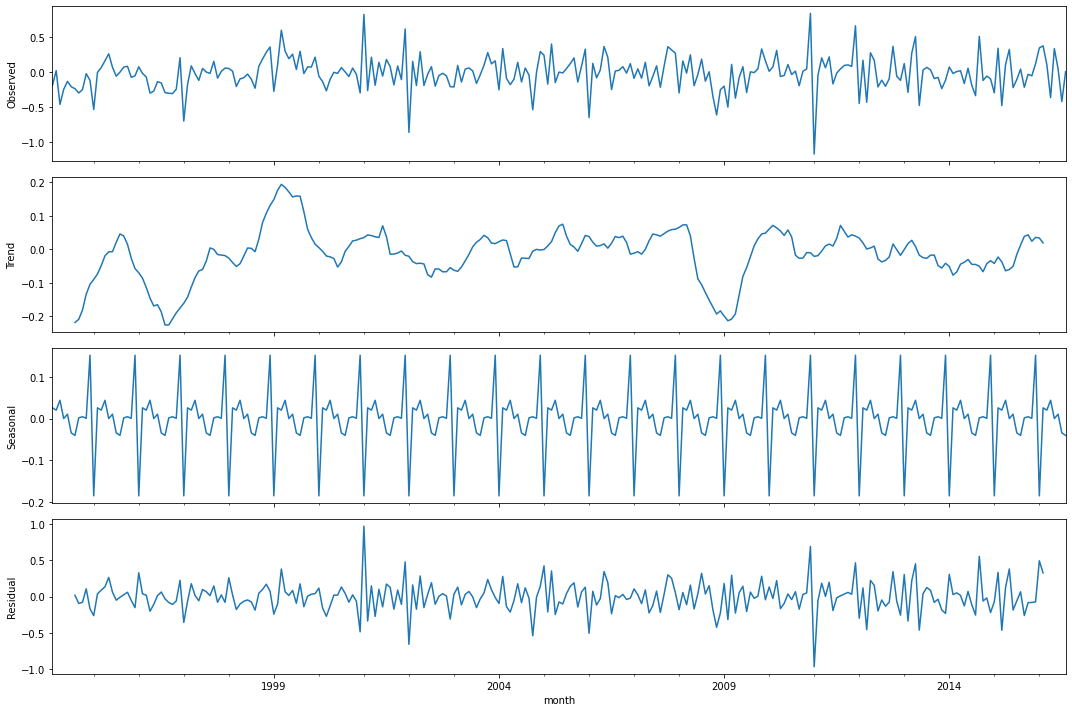

In [24]:
salary['salary_box_diff2'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff2[13:])[1])

In [30]:
salary.salary_box_diff2[:20]

month
1993-01-01         NaN
1993-02-01         NaN
1993-03-01         NaN
1993-04-01         NaN
1993-05-01         NaN
1993-06-01         NaN
1993-07-01         NaN
1993-08-01         NaN
1993-09-01         NaN
1993-10-01         NaN
1993-11-01         NaN
1993-12-01         NaN
1994-01-01         NaN
1994-02-01   -0.192106
1994-03-01    0.017208
1994-04-01   -0.464255
1994-05-01   -0.249685
1994-06-01   -0.134766
1994-07-01   -0.211766
1994-08-01   -0.240059
Name: salary_box_diff2, dtype: float64

Критерий Дики-Фуллера уверенно отвергает гипотезу о нестационарности. Тренд колеблется около постоянного значения. Делаем вывод о стационарности полученного ряда и идём дальше.


4. Выбор начальных приближений для p, q, P, Q.

Посмотрим на ACF и PACF полученного ряда:

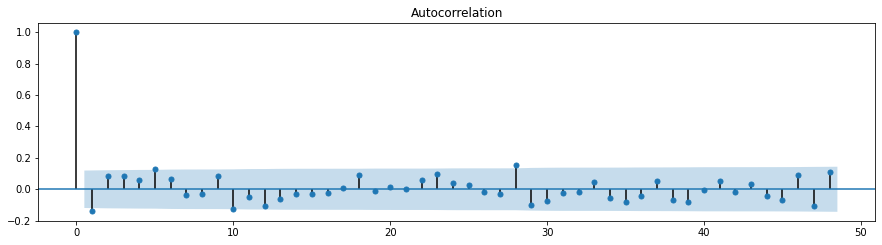

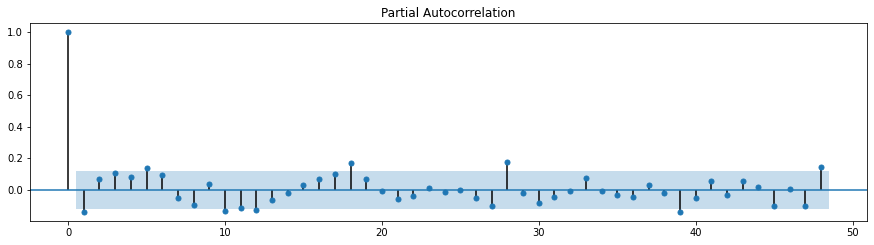

In [31]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Q (номер последнего сезонного лага, при котором автокорреляция значима) = 0, так как значимых сезонных лагов на графике автокорреляции не наблюдается.

q (номер последнего несезонного лага, при котором автокорреляция значима) возьмём равным 1, так как следующий значимый несезонный лаг слишком большой.

P (номер последнего сезонного лага, при котором частичная автокорреляция значима) = 48/12 = 4.

p (номер последнего несезонного лага, при котором частичная автокорреляция значима) попробуем взять 5, так как следующие несезонные нали досаточно большие.

5. Обучение и сравнение моделей-кандидатов, выбор победителя.

In [92]:
ps = range(0, 6)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [93]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [94]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 3min 49s, sys: 2min 33s, total: 6min 23s
Wall time: 3min 19s


In [95]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
56  (5, 1, 1, 0) -5.260132
36  (3, 1, 1, 0) -4.995860
51  (5, 0, 1, 0) -4.545933
59  (5, 1, 4, 0) -4.469889
54  (5, 0, 4, 0) -4.238184


In [96]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 1)x(1, 1, 0, 12)   Log Likelihood                  10.630
Date:                            Wed, 29 Jul 2020   AIC                             -5.260
Time:                                    10:08:31   BIC                             23.557
Sample:                                01-01-1993   HQIC                             6.310
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2016      0.436      0.462      0.644      -0.654       1.057
ar.L2          0.0993      0.105   

Остатки:

Критерий Стьюдента: p=0.296184
Критерий Дики-Фуллера: p=0.000000


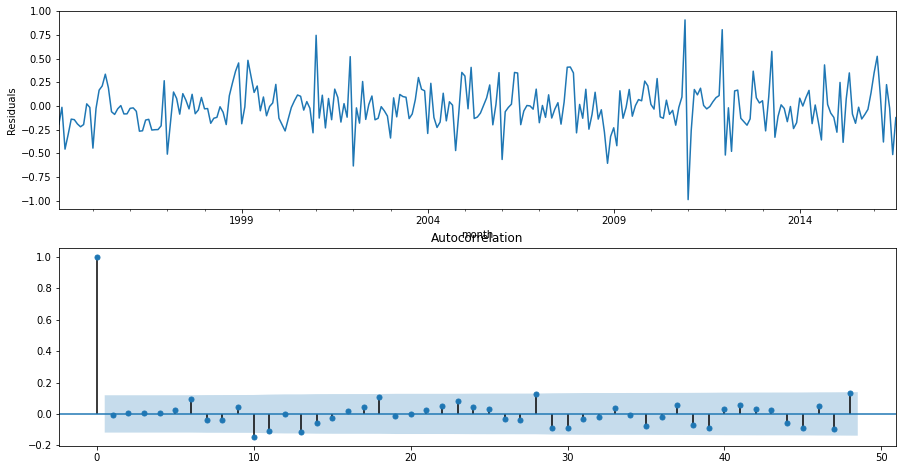

In [97]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально). Значение достигаемого уровня значимости критерия Льюнга-Бокса является пограничным p=0.27, т.е. остатки не автокоррелированы.

7. Прогнозирование с помощью финальной модели.

In [98]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

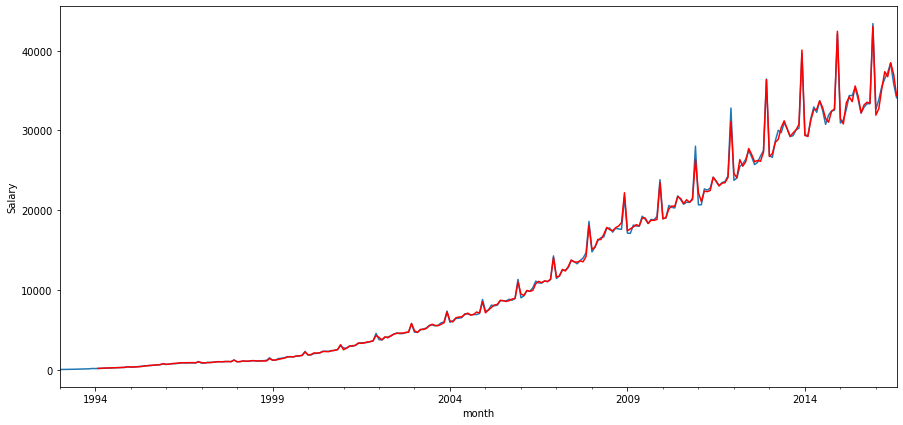

In [99]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

Как видно, модель хорошо описывает наши данные.

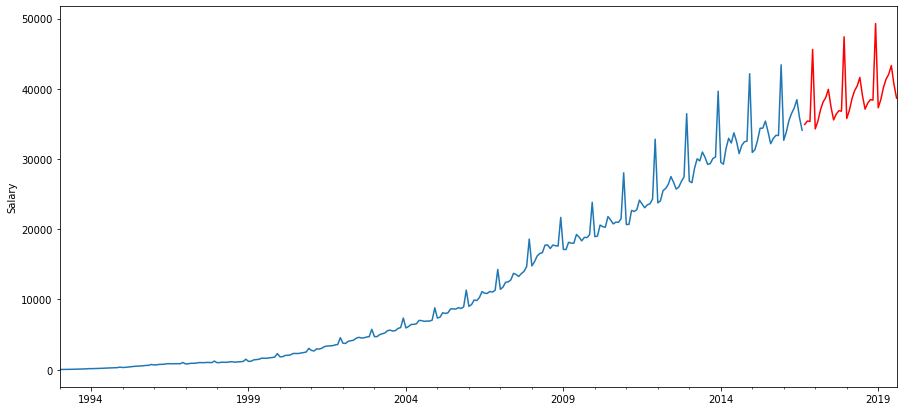

In [100]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=319), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()

Прогноз выглядит очень реалистично.